In [1]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision as tv

import pytorch_lightning as pl

import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

In [2]:
# Normalized Value
# GRay SCale
mean= torch.tensor([58.5441])
std= torch.tensor([31.2263])
# RGB
# mean = torch.tensor([63.7968, 56.8070, 53.6988])
# std = torch.tensor([33.8220, 31.6433, 31.0874])

In [3]:
class IndianCeleb(pl.LightningDataModule):
    def __init__(self, root, imgsz, batchsz, no_workers):
        super(IndianCeleb, self).__init__()
        self.root = root
        self.imgsz = imgsz
        self.batchsz = batchsz
        self.num_workers = no_workers

        self.transform = transforms.Compose(
            [transforms.Resize(self.imgsz),
             transforms.CenterCrop(self.imgsz),
             transforms.Grayscale(num_output_channels=1),
             # transforms.AutoAugment(), #imagenet
               
             transforms.ToTensor(),
            transforms.Normalize(mean,std)
            ]
        )

    def setup(self, stage):
        if stage == "fit" or stage is None:
            self.train_dataset = datasets.ImageFolder(
                root=os.path.join(self.root, "train"),transform=self.transform
            )
            self.val_dataset = datasets.ImageFolder(
                root=os.path.join(self.root, "validation"),transform=self.transform
            )

        if stage == "test" or stage is None:
            self.test_dataset = datasets.ImageFolder(
                root=os.path.join(self.root, "test"),transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batchsz,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batchsz,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batchsz,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [4]:
root ="../data/indianCeleb/"
imgsz = 256
batchsz = 16
no_workers = 16
ds = IndianCeleb(root, imgsz, batchsz, no_workers)

torch.Size([16, 1, 256, 256])


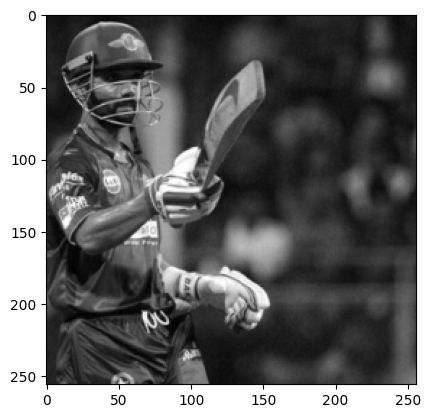

In [5]:

# Sanity Check
ds.setup('fit')
dataloader = ds.train_dataloader()

for x,label in dataloader:
    print(x.shape)
    x = x * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)
    plt.imshow(x[14].permute(1,2,0),cmap="grey")
    break

In [6]:
# ## Let's Normalize the dataset
# ## 
# total_sample = 0
# mean_sum = torch.zeros(3)
# std_sum = torch.zeros(3)

# for x,label in dataloader:
#     batch_size = x.size(0)
#     x_trans = x.view(batch_size,x.size(1),-1)
#     batch_mean = x_trans.mean(dim=2).sum(0)
#     batch_std = x_trans.std(dim=2).sum(0)

#     # Update accumulators
#     mean_sum += batch_mean * batch_size
#     std_sum += batch_std * batch_size
#     total_sample += batch_size


# mean = mean_sum/ total_sample
# std = std_sum/ total_sample
# print("mean:",mean)
# print("std:",std)



In [7]:
class Autoencoder(pl.LightningModule):
    
    def __init__(self,input_size,hidden_size,latent_size,output_size,lr=1e-3):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(input_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,latent_size))
        self.decoder = nn.Sequential(nn.Linear(latent_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,input_size),nn.Sigmoid())
        
        self.learning_rate = lr
        
        
    def forward(self,x):
        z = self.encoder(x)
        return self.decoder(z)
    
    def training_step(self, batch):
        x, _ = batch
        loss = self._common_step(batch)
        lr = self.optimizers().param_groups[0]['lr']
        
        self.log_dict({'train_loss':loss,'learning_rate':lr},prog_bar=True,on_step=False,on_epoch=True)        
        return loss
    
    
    def validation_step(self, batch):
        loss = self._common_step(batch)
        
        self.log_dict({'val_loss':loss},prog_bar=True,on_step=False,on_epoch=True)
        
        return loss

    def test_step(self, batch):
        loss = self._common_step(batch)
        
        self.log_dict({'test_loss':loss},prog_bar=True,on_step=False,on_epoch=True)
        return loss

    def _common_step(self,batch):
        x, _ = batch
        x = x.flatten(start_dim=1)
        x_hat = self.forward(x)
        loss = nn.functional.binary_cross_entropy(x_hat,abs(x)/255) #For Binary Cross Entropy all elements of targets should be between 0 and 1
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [8]:
input_size = imgsz *imgsz 
hidden_size = 1024
latent_size = 256
output_size = imgsz *imgsz 
learning_rate = 9e-6

In [9]:
model = Autoencoder(input_size, hidden_size, latent_size, output_size, lr=learning_rate)


In [10]:
model = torch.compile(model)
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

In [11]:
trainer = pl.Trainer(min_epochs=1,
                        max_epochs=50 ,
                        # precision='16-mixed',
                        enable_model_summary=False,
                        callbacks=[pl.callbacks.EarlyStopping('val_loss')],
                        enable_checkpointing  = False,
                        log_every_n_steps=10
                    )
trainer.fit(model,ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/pranav-pc/.env/lib/python3.12/site-packages/torch/_dynamo/variables/functions.py:663: UserWarning: Graph break due to unsupported builtin None.dict.update. This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind). If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround. If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use torch.compiler.allow_in_graph.
  torch._dynamo.utils.warn_once(msg)


Training: |                                               | 0/? [00:00<?, ?it/s]

W0905 21:36:11.206000 136142740398208 torch/_dynamo/convert_frame.py:762] [31/8] torch._dynamo hit config.cache_size_limit (8)
W0905 21:36:11.206000 136142740398208 torch/_dynamo/convert_frame.py:762] [31/8]    function: 'update_metrics' (/home/pranav-pc/.env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:416)
W0905 21:36:11.206000 136142740398208 torch/_dynamo/convert_frame.py:762] [31/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0905 21:36:11.206000 136142740398208 torch/_dynamo/convert_frame.py:762] [31/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0905 21:36:11.206000 136142740398208 torch/_dynamo/convert_frame.py:762] [31/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Validation: |                                             | 0/? [00:00<?, ?it/s]

W0905 21:36:27.840000 136142740398208 torch/_dynamo/convert_frame.py:762] [37/8] torch._dynamo hit config.cache_size_limit (8)
W0905 21:36:27.840000 136142740398208 torch/_dynamo/convert_frame.py:762] [37/8]    function: 'forward' (/home/pranav-pc/.env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:263)
W0905 21:36:27.840000 136142740398208 torch/_dynamo/convert_frame.py:762] [37/8]    last reason: GLOBAL_STATE changed: grad_mode 
W0905 21:36:27.840000 136142740398208 torch/_dynamo/convert_frame.py:762] [37/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0905 21:36:27.840000 136142740398208 torch/_dynamo/convert_frame.py:762] [37/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
W0905 21:36:30.381000 136142740398208 torch/_dynamo/convert_frame.py:762] [38/8] torch._dynamo hit config.cache_size_limit (8)
W0905 21:36:30.381000 136142740398208 torch/_dynamo/convert_fr

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [12]:
# tune = pl.tuner.Tuner(trainer)
# lr_finder = tune.lr_find(model,train_dataloaders=ds,num_training=500,min_lr=9e-7, max_lr=1e-2);
# lr_finder.plot(suggest=True);

In [19]:

model.eval()
trainer.validate(model, ds)
trainer.test(model, ds)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.04316523298621178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.043163370341062546
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.043163370341062546}]

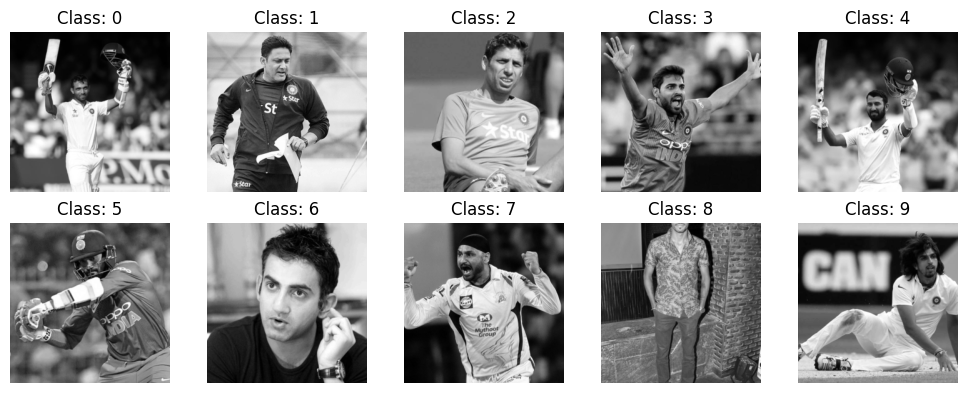

In [15]:

# Create a dictionary to store one image per class
class_images = {}

# Iterate over the dataset and store one image per class
for image, label in ds.train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Stop after storing one image per class
            break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Class: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.flatten(start_dim=1))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
            
def plot_reconstructed(autoencoder, r0=(-15, 20), r1=(-5, 20), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

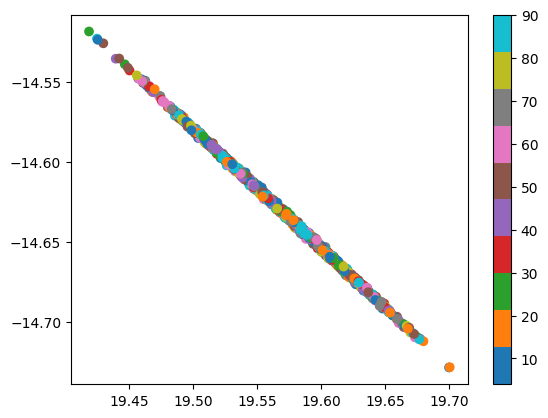

In [22]:

plot_latent(model,ds.train_dataloader())